## Native Frame Use Case

This case involves data extracted from the Chandra Source Catalog, Release 2.0 containing Source ID and Position in 2 reference frames (ICRS, GALACTIC).

The primary goals of the case appear to be
* Illustrate that the model allows for >1 instance of any given Property
    * Positions in multiple reference frames
* Demonstrate the ability to reconcile Positions in different frames.

In [1]:
import sys
import os
from rama.reader import Reader
from rama.reader.votable import Votable

from rama.models.mango import Source
from rama.models.measurements import Position
from rama.models.coordinates import LonLatPoint

from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.coordinates import FK5

infile = './data/vizier_csc2_gal.avot'

### Load Data - find Positions

In [2]:
# Open the VOTable
doc = Reader( Votable(infile) )

# Extract Source instances
catalog = doc.find_instances(Source)[0]

# Identify the Position properties
#   * finds all positions in the file
positions = doc.find_instances(Position)

print("Catalog contains:")
print("  o {} Sources".format(len(catalog.identifier)))
print("  o {} Positions per source".format(len(positions)))


Catalog contains:
  o 10 Sources
  o 2 Positions per source


In [3]:
# A somewhat more robust means of finding the Position properties is 
# is to scan them directly according to the data models.
#  * this will eliminate things like "Target.position" from the results.

positions = []
for param in ( catalog.parameter_dock ):
    if ( type(param.measure) == Position ):

        # NOTE: rama auto-converts Point coordinate instances to AstroPy SkyCoord instances.
        #   which have a different interface.  It is likely more appropriate to have
        #   a conversion method ( asSkyCoord() ) on the Point class, so this sort of 
        #   case handling is not necessary.
        if isinstance( param.measure.coord, SkyCoord ):
            frame = param.measure.coord.frame.name
        else:
            frame = param.measure.coord.coord_sys.space_ref_frame
        
        print("  o Found Position in '{}' frame".format(frame))
        positions.append( param.measure )


  o Found Position in 'icrs' frame
  o Found Position in 'galactic' frame


### Convert Position to AstroPy SkyCoord

In [4]:
# As noted above, the coord:Point may be auto-converted to AstroPy SkyCoord by the rama package.
# The following illustrates how that is done.
coords = []
for pos in positions:
    sky = None
    if ( type(pos.coord), SkyCoord ):
        # already converted
        sky = pos.coord
    elif ( type(pos.coord), LonLatPoint ):
        # convert
        sky = SkyCoord( pos.coord.lon, 
                        pos.coord.lat, 
                        frame=pos.coord.coord_sys.frame.space_ref_frame.lower(),
                        equinox=pos.coord.coord_sys.frame.equinox,
                        unit=pos.coord.lon.unit )
    coords.append( sky )

### Convert both to a common reference frame

In [5]:
# Use the AstroPy SkyCoord methods to transform the data
#  * we are choosing FK5 with an equinox of J2015.5

coords_common = []
for coord in coords:
    coords_common.append( coord.transform_to(FK5(equinox="J2015.5")))


### Show the conversion has happened

In [6]:
print("Original Coordinates:")
print("  o A: type={}, frame={}".format(str(type(coords[0])), coords[0].frame.name ))
print("  o B: type={}, frame={}".format(str(type(coords[1])), coords[1].frame.name ))
print("")
print("Uniform Coordinates:")
print("  o A: type={}, frame={}".format(str(type(coords_common[0])), coords_common[0].frame.name ))
print("  o B: type={}, frame={}".format(str(type(coords_common[1])), coords_common[1].frame.name ))


Original Coordinates:
  o A: type=<class 'astropy.coordinates.sky_coordinate.SkyCoord'>, frame=icrs
  o B: type=<class 'astropy.coordinates.sky_coordinate.SkyCoord'>, frame=galactic

Uniform Coordinates:
  o A: type=<class 'astropy.coordinates.sky_coordinate.SkyCoord'>, frame=fk5
  o B: type=<class 'astropy.coordinates.sky_coordinate.SkyCoord'>, frame=fk5


### Make Plots

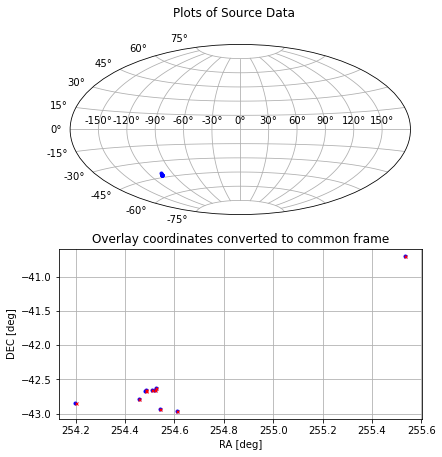

In [7]:
from astropy import units as u
import matplotlib.pyplot as plt

coords1 = coords_common[0] # originally ICRS, now FK5
coords2 = coords_common[1] # originally GALACTIC, now FK5

plt.figure( figsize=(6.5,6.5) )
plt.suptitle("Plots of Source Data")
plt.subplots_adjust(top=0.90,bottom=0.1)

# as AITOFF projection
ax1 = plt.subplot(211, projection="aitoff")
ax1.grid(True)

ra_rad  = coords1.ra.wrap_at(180 * u.deg).radian
dec_rad = coords1.dec.radian
plt.plot(ra_rad, dec_rad, 'o', markersize=3, color="blue")

# as regular grid
ax2 = plt.subplot(212)
ax2.set_title("Overlay coordinates converted to common frame")
ax2.grid(True)
ax2.set_xlabel("RA [%s]"%coords1.ra.unit)
ax2.set_ylabel("DEC [%s]"%coords1.dec.unit)

plt.plot( coords1.ra, coords1.dec,'o', markersize=3, color='blue')
plt.plot( coords2.ra, coords2.dec,'x', markersize=3, color='red')

# save the plot
plt.savefig("temp/native_frame_plot.png")
